### Autoencoders 

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [46]:
torch.manual_seed(0)

In [47]:
input_size = 784
h1 = 500
h2 = 300
bottleneck = 200
h3 = 300
h4 = 500
lr = 0.001
number_epoch = 5000
batch_size = 100

In [48]:
class Noisify:
    def __init__(self, Noise_level):
        self.Noise_level = Noise_level
    def __call__(self, sample):
        clean_image = sample[0]
        noise = self.Noise_level * np.random.normal(0, 1, size=clean_image.shape)
        Noisy_image = clean_image + noise
        All_images = (Noisy_image, clean_image)
        return All_images

In [5]:
transformation = transforms.Compose([transforms.ToTensor(),  Noisify(0.15)])
batch_size = 100

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class Denoising_Autoencoder(nn.Module):
    def __init__(self, input_size, h1, h2, bottleneck, h3, h4):
        super(Denoising_Autoencoder, self).__init__()
        self.el1 = nn.Linear(input_size, h1)
        self.el2 = nn.Linear(h1, h2)
        self.el3 = nn.Linear(h2, bottleneck)

        self.Relu = nn.ReLU()

        self.d11 = nn.Linear(bottleneck, h3)
        self.dl2 = nn.Linear(h3, h4)
        self.dl3 = nn.Linear(h4, input_size)

    def encoder_forward(self, Noisy_image):

        out = self.el1(Noisy_image)
        out = self.Relu(out)
        out = self.el2(out)
        out = self.Relu(out)
        out = self.el3(out)
        
        return out
    
    def decoder_forward(self, encoded_forward):

        out = self.d11(encoded_forward)
        out = self.Relu(out)
        out = self.dl2(out)
        out = self.Relu(out)
        out = self.dl3(out)
        
        return out
    def forward(self, Noisy_image):
        encoder_forward = self.encoder_forward(Noisy_image)
        decoded_forward = self.decoder_forward(encoder_forward)
        return decoded_forward

    

In [ ]:
Model = Denoising_Autoencoder(input_size, h1, h2, bottleneck, h3, h4)
Cost = nn.MSELoss()
optimizer = optim.Adam(Model.parameters(), lr=lr)
number_epouch = 100

for epoch in range(number_epouch):
    for i , ((Noisy_image, clean_image), label) in enumerate(train_loader):       
        #Forward pass
        Noisy_image, clean_image = Noisy_image.reshape(-1, input_size), clean_image.reshape(-1, input_size)

        Noisy_image = Noisy_image.type(torch.float32)
        clean_image = clean_image.type(torch.float32)

        output = Model.forward(Noisy_image)
        loss = Cost(output, clean_image)

        #backpropogation

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{number_epouch}], Loss: {loss.item():.4f}')



In [37]:
def Denoise(Model, Noisy_image):
    with torch.no_grad():
        Noisy_image =  Noisy_image.reshape(-1, input_size)
        Noisy_image = Noisy_image.type(torch.float32)
        encoder_forward = Model.encoder_forward(Noisy_image)
        output = Model.decoder_forward(encoder_forward)
        output = output.reshape(28, 28)
        output = output.detach().numpy()
    return output 

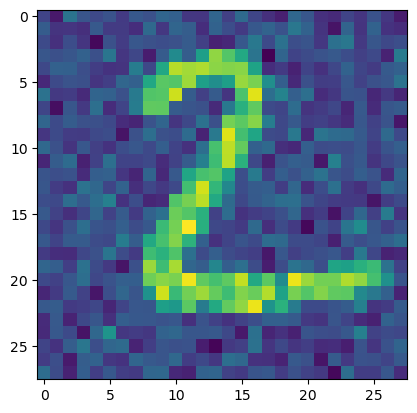

In [40]:
(Noisy_image, clean_image), label = next(iter(test_loader))
plt.imshow(Noisy_image[1])


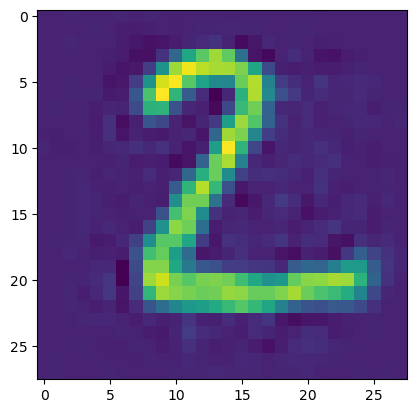

In [49]:
test_image = Noisy_image[1]
cleaned_test_image = Denoise(Model, test_image)
plt.imshow(cleaned_test_image)